**Programming Assignment - 2 : Actor-Critic n-step and full return**

In [1]:

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
#from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.3 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


In [1]:
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
#from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [2]:
class ActorCriticModel(nn.Module):
  
  def __init__(self,input_size,action_size, n_hidden1=1024, n_hidden2=512):
    super(ActorCriticModel,self).__init__()

    self.fc1=nn.Linear(input_size,n_hidden1)
    self.fc2=nn.Linear(n_hidden1,n_hidden2)
    self.pi_out=nn.Linear(n_hidden2,action_size)
    self.v_out=nn.Linear(n_hidden2,1)
    self.relu=nn.ReLU()
    self.softmax=nn.Softmax(dim=1)

  def forward(self,state):

    x=self.fc1(state)
    x=self.relu(x)
    x=self.fc2(x)
    x=self.relu(x)
    v=self.v_out(x)
    x=self.pi_out(x)
    pi=self.softmax(x)

    return pi,v

In [3]:
class Agent:

  def __init__(self, input_size,action_size, lr=0.001, gamma=0.99, seed = 85):

    self.gamma=gamma
    self.action_size=action_size
    self.ac_model=ActorCriticModel(input_size=input_size,action_size=action_size)
    self.optimizer=optim.Adam(self.ac_model.parameters(),lr=lr)
    np.random.seed(seed)

  def sample_action(self,state):

    pi,_=self.ac_model(state)
    prob=pi.squeeze().detach().numpy()
    action=np.random.choice(self.action_size,p=prob)

    return action

  def actor_loss(self,action,pi,delta):

    return -torch.log(pi[0,action])*delta

  def critic_loss(self,delta):
    
    return delta**2
  
  def update(self,loss):
    loss=loss.clone()
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()



  def learn(self,states,actions,rewards,n,method):

        length=len(states)
        pi_list=[]
        bootstrap_val=[]
        val_state=[]
        rewards=np.concatenate((np.array(rewards),np.zeros(n)))
        
        if method=="n-step":
          discount_window=[]
          for i in range(n+1):
            discount_window.append(self.gamma**i)
          discount_window=torch.tensor(discount_window)
        
        for i,state in enumerate(states):
          pi, V_s = self.ac_model(state)
          _, V_s_next = self.ac_model(states[min(i+n,length-1)])
          V_s=V_s.squeeze()
          V_s_next = V_s_next.squeeze()
          pi_list.append(pi)
          val_state.append(V_s)
          bootstrap_val.append(V_s_next)  
        
        if method=='n-step':   
        
          loss_total=0
          for i,next_state_val,state_val in zip(np.arange(length-1),bootstrap_val[:-1],val_state[:-1]):
            target=torch.cat((torch.from_numpy(rewards[i:i+n]),next_state_val.reshape(1))).to(torch.float32)
            delta=torch.dot(discount_window,target)-state_val
            loss_a = self.actor_loss(actions[i], pi_list[i], delta)
            loss_c = self.critic_loss(delta)
            loss_total+= loss_a + loss_c
          self.update(loss_total)

        else:
          loss_total=0
          for i,state_val in zip(np.arange(length-1),val_state[:-1]):
            target=(torch.from_numpy(rewards[i:length-1])).to(torch.float32)
            discount_window=[]
            for j in range(length-1-i):
              discount_window.append(self.gamma**j)
            discount_window=torch.tensor(discount_window)
            delta=torch.dot(discount_window,target)-state_val
            loss_a = self.actor_loss(actions[i], pi_list[i], delta)
            loss_c =self.critic_loss(delta)
            loss_total+= loss_a + loss_c
          self.update(loss_total)
        

# $CartPole\:$
Full-step return configuration

In [ ]:

env = gym.make('CartPole-v0')
req_score=150

#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 2500

# tf.compat.v1.reset_default_graph()
gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=100 # not used
steps_his=[]

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew += reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,"Full-step")
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))
    


    if ep % 100 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  100 Reward 39.000000 Average Reward 23.600000
Episode  200 Reward 19.000000 Average Reward 24.000000
Episode  300 Reward 43.000000 Average Reward 44.600000
Episode  400 Reward 87.000000 Average Reward 81.300000
Episode  500 Reward 141.000000 Average Reward 112.300000
Episode  600 Reward 48.000000 Average Reward 88.000000
Episode  700 Reward 133.000000 Average Reward 156.800000
Episode  800 Reward 200.000000 Average Reward 149.200000
Stopped at Episode  811
0:02:26.744644


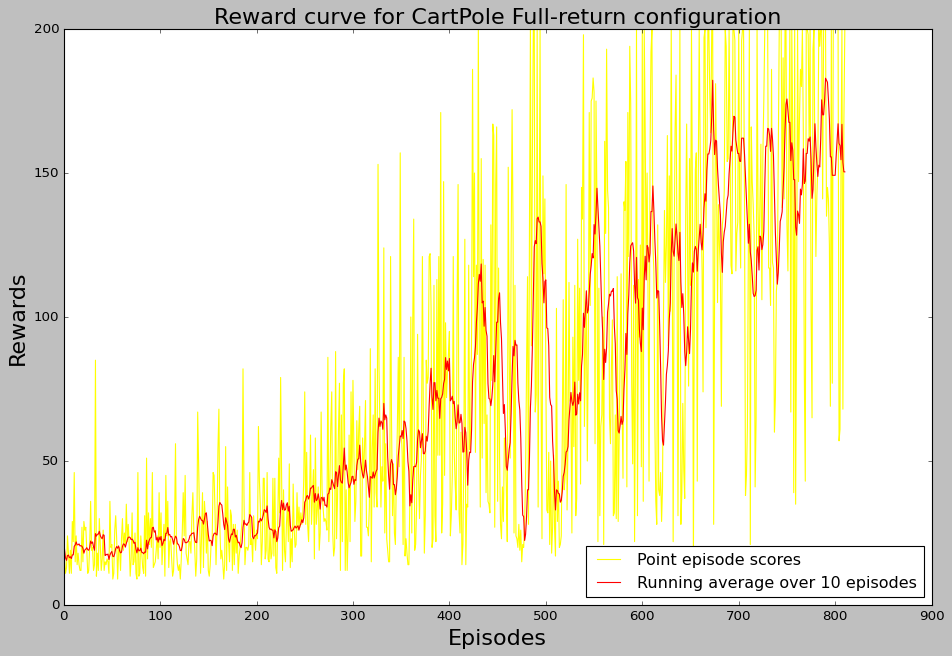

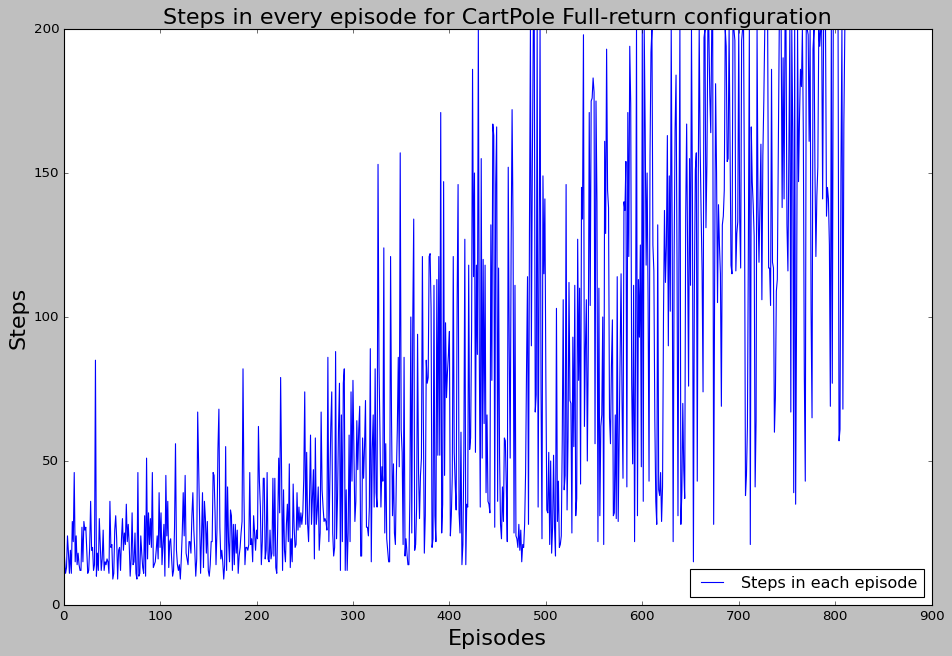

In [ ]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for CartPole Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for CartPole Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.show()

# $CartPole\:$
n-step return configuration with n = 20

In [ ]:
#Learning rate 1e-4 and n = 100
env = gym.make('CartPole-v1')
req_score=150


#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 2500
# tf.compat.v1.reset_default_graph()
gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=20
steps_his=[]

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew += reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,"n-step")
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 100 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  100 Reward 12.000000 Average Reward 37.600000
Episode  200 Reward 74.000000 Average Reward 66.200000
Episode  300 Reward 21.000000 Average Reward 47.200000
Episode  400 Reward 176.000000 Average Reward 77.300000
Episode  500 Reward 30.000000 Average Reward 89.300000
Episode  600 Reward 86.000000 Average Reward 98.200000
Episode  700 Reward 100.000000 Average Reward 135.200000
Stopped at Episode  760
0:03:02.875757


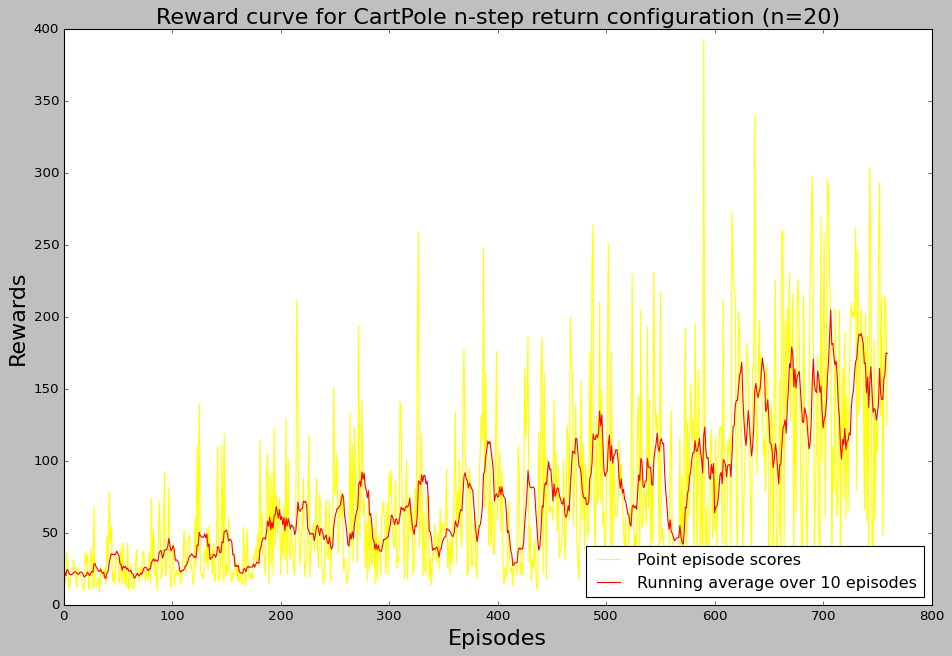

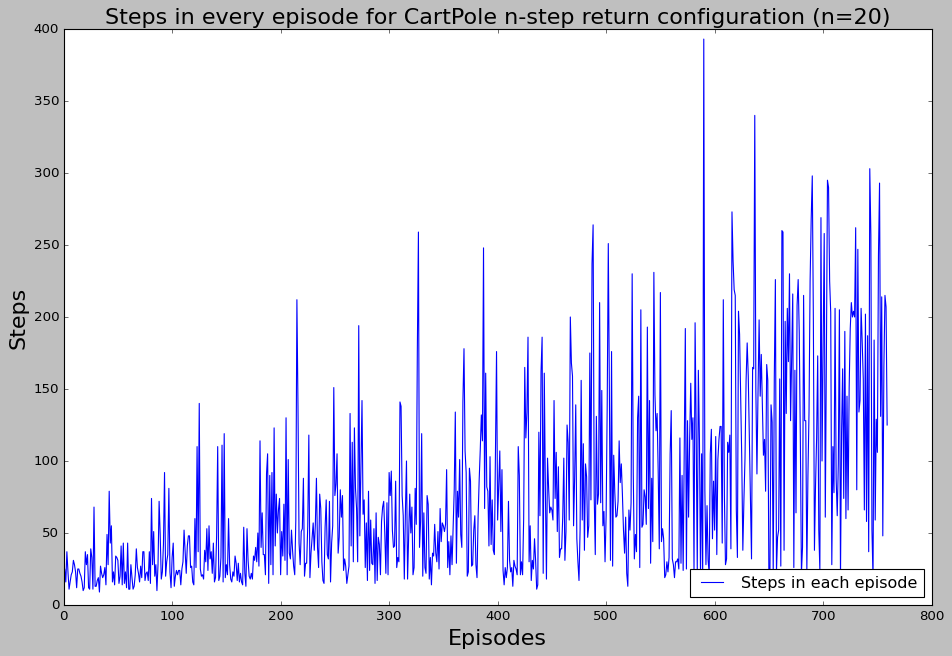

In [ ]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for CartPole n-step return configuration (n=20)',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for CartPole n-step return configuration (n=20)',fontsize=20)
plt.legend(loc='lower right')
plt.show()

# $CartPole\:$
n-step return configuration with n = 50

In [ ]:
#Learning rate 1e-4 and n = 100
env = gym.make('CartPole-v1')
req_score=150


#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 2500
# tf.compat.v1.reset_default_graph()
gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=50
steps_his=[]

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew += reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,"n-step")
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 100 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  100 Reward 20.000000 Average Reward 23.900000
Episode  200 Reward 24.000000 Average Reward 45.900000
Episode  300 Reward 129.000000 Average Reward 79.600000
Episode  400 Reward 137.000000 Average Reward 103.000000
Episode  500 Reward 71.000000 Average Reward 127.900000
Episode  600 Reward 199.000000 Average Reward 151.100000
Episode  700 Reward 16.000000 Average Reward 116.000000
Episode  800 Reward 205.000000 Average Reward 115.000000
Episode  900 Reward 57.000000 Average Reward 92.400000
Episode  1000 Reward 54.000000 Average Reward 153.900000
Episode  1100 Reward 239.000000 Average Reward 160.200000
Stopped at Episode  1171
0:05:13.691792


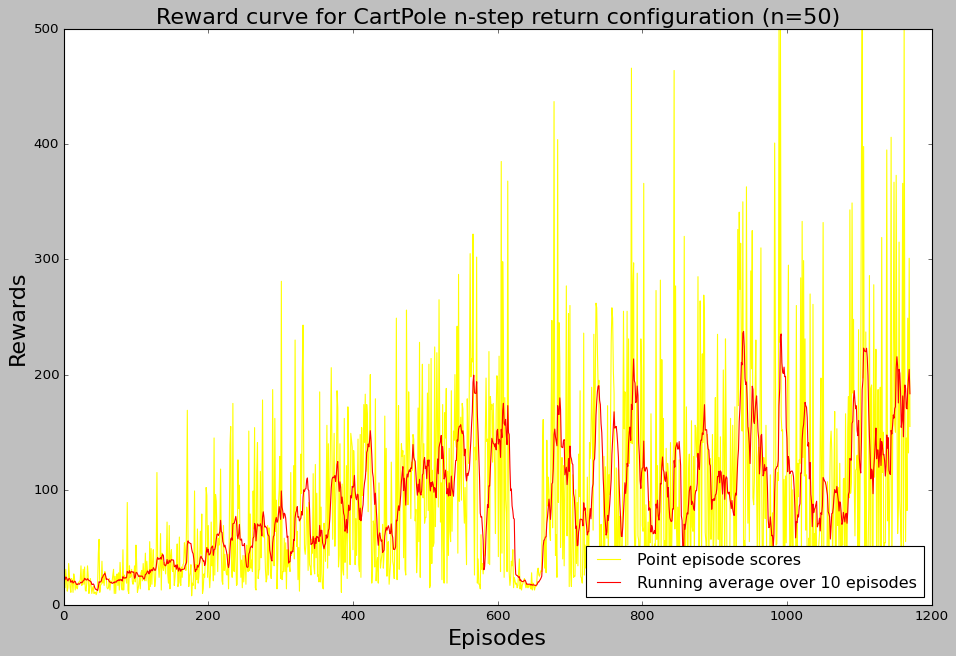

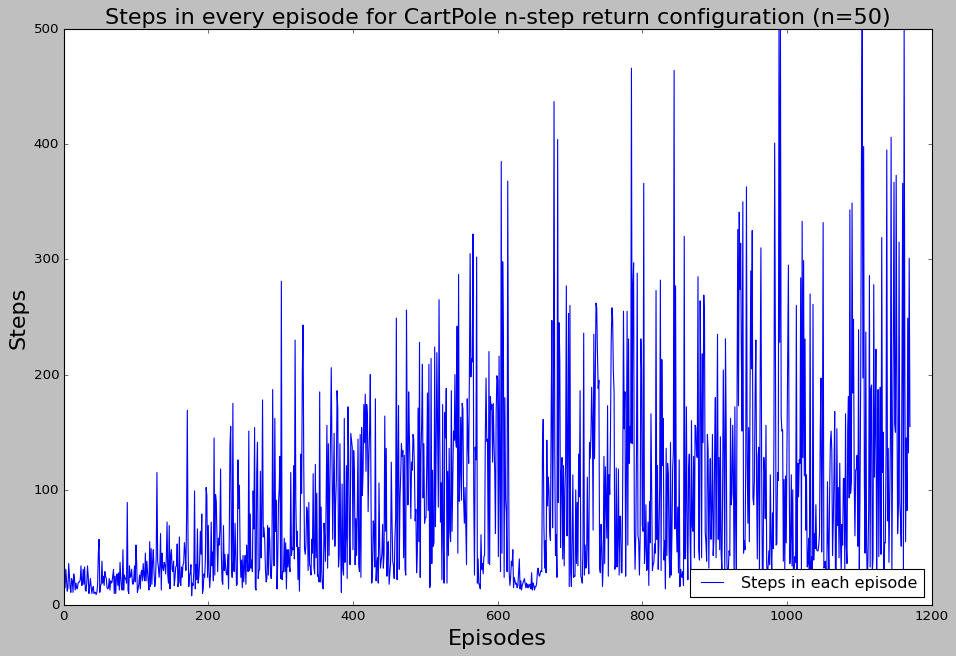

In [ ]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for CartPole n-step return configuration (n=50)',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for CartPole n-step return configuration (n=50)',fontsize=20)
plt.legend(loc='lower right')
plt.show()

# $Acrobot\:$
n-step return configuration with n = 4

In [ ]:
#Leaning rate = 1e-4 and n = 4
env = gym.make('Acrobot-v1')
req_score=-200

#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 1800
# tf.compat.v1.reset_default_graph()
gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=4
steps_his=[]

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew += reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,"n-step")
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 50 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  50 Reward -500.000000 Average Reward -500.000000
Episode  100 Reward -500.000000 Average Reward -477.400000
Episode  150 Reward -500.000000 Average Reward -490.100000
Episode  200 Reward -500.000000 Average Reward -452.700000
Episode  250 Reward -214.000000 Average Reward -185.300000
Episode  300 Reward -133.000000 Average Reward -176.700000
Stopped at Episode  316
0:06:23.468290


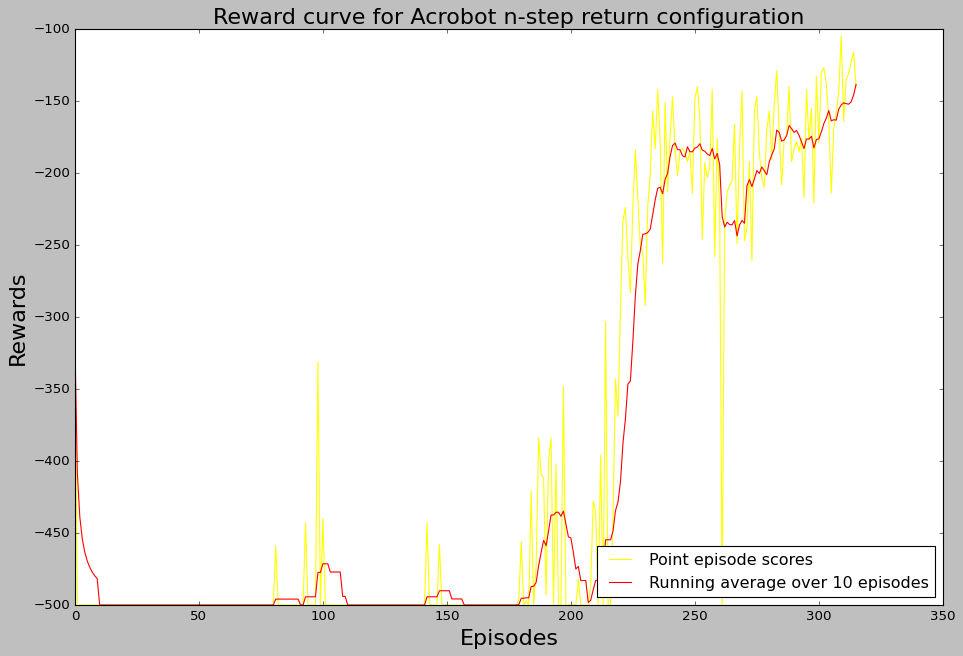

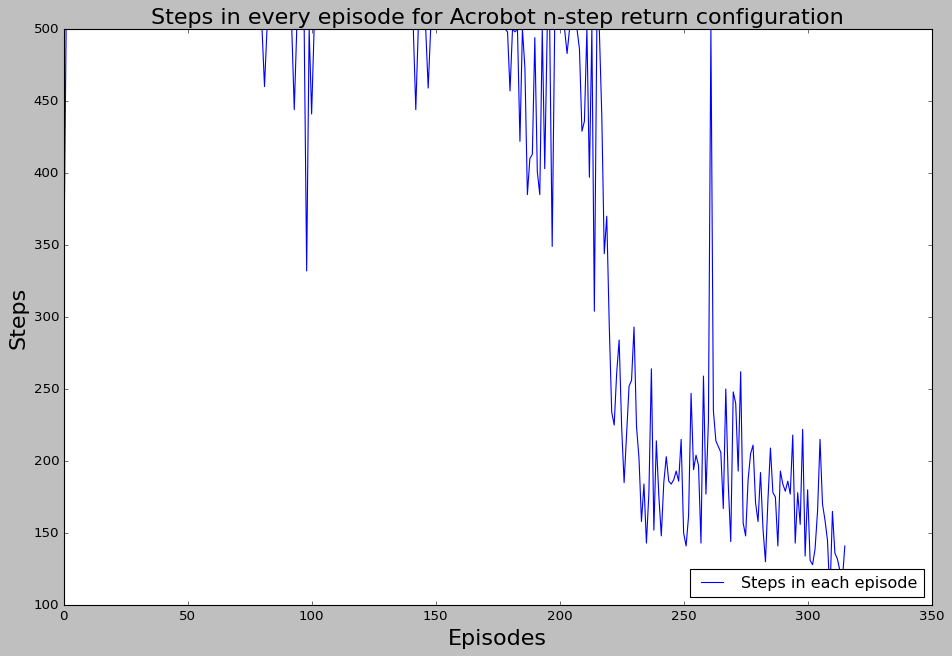

In [ ]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for Acrobot n-step return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for Acrobot n-step return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.show()

# $Acrobot\:$
n-step return configuration with n = 15

In [ ]:
#Leaning rate = 1e-4 and n = 4
env = gym.make('Acrobot-v1')
req_score=-200

#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 1800
# tf.compat.v1.reset_default_graph()
gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=15
steps_his=[]

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew += reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,"n-step")
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 50 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  50 Reward -500.000000 Average Reward -479.800000
Episode  100 Reward -500.000000 Average Reward -500.000000
Episode  150 Reward -500.000000 Average Reward -500.000000
Episode  200 Reward -500.000000 Average Reward -500.000000
Episode  250 Reward -500.000000 Average Reward -500.000000
Episode  300 Reward -500.000000 Average Reward -500.000000
Episode  350 Reward -453.000000 Average Reward -381.300000
Episode  400 Reward -220.000000 Average Reward -297.800000
Episode  450 Reward -214.000000 Average Reward -206.800000
Episode  500 Reward -238.000000 Average Reward -284.500000
Episode  550 Reward -405.000000 Average Reward -289.500000
Episode  600 Reward -309.000000 Average Reward -260.500000
Episode  650 Reward -176.000000 Average Reward -221.200000
Stopped at Episode  682
0:13:14.951125


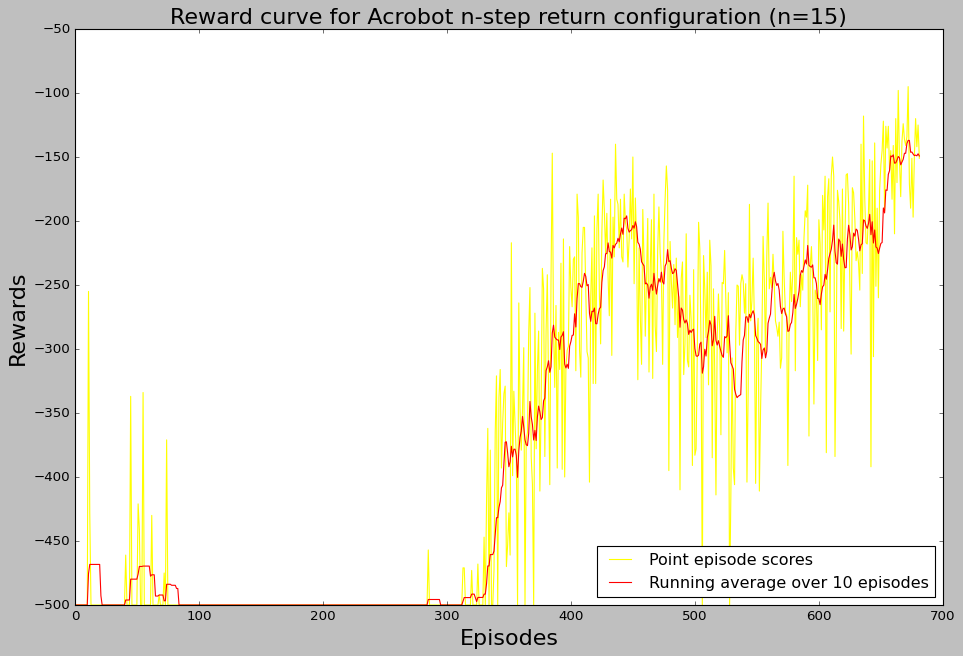

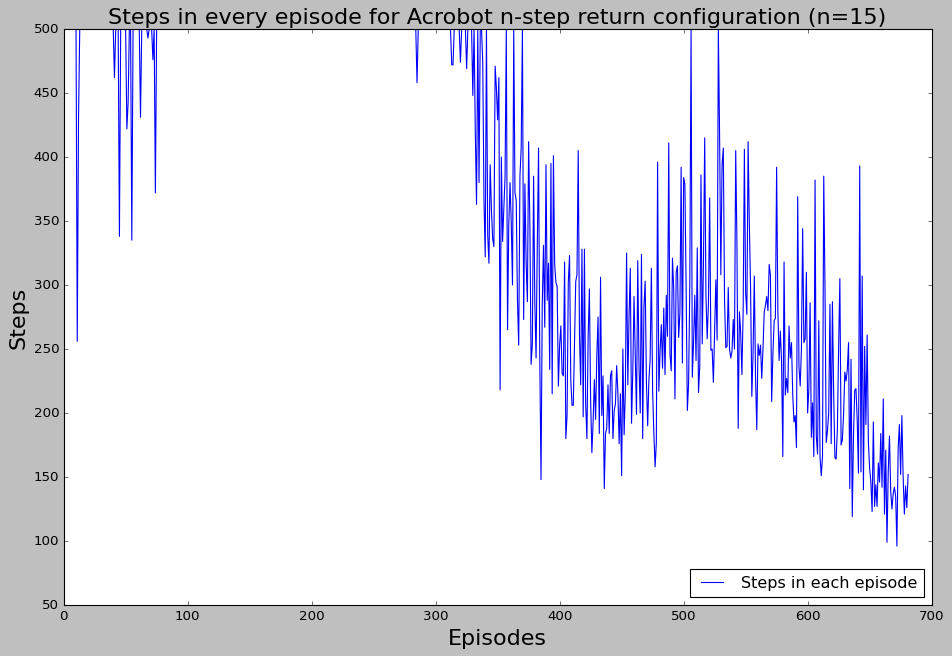

In [ ]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for Acrobot n-step return configuration (n=15)',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for Acrobot n-step return configuration (n=15)',fontsize=20)
plt.legend(loc='lower right')
plt.show()

# $Acrobot\:$
Full-return configuration

In [ ]:
#Full-step with this code 1e-4 working but diverging.5e-4 not working
#Solved!. 1e-5 and n=4 but n not needed
env = gym.make('Acrobot-v1')
req_score=-200

#Initializing Agent
agent = Agent(lr=1e-2, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 2500

# tf.compat.v1.reset_default_graph()

gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=4
steps_his=[]

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew += reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,"full-step")
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 50 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  50 Reward -500.000000 Average Reward -500.000000
Episode  100 Reward -500.000000 Average Reward -500.000000
Episode  150 Reward -500.000000 Average Reward -500.000000
Episode  200 Reward -500.000000 Average Reward -500.000000
Episode  250 Reward -500.000000 Average Reward -500.000000
Episode  300 Reward -500.000000 Average Reward -500.000000
Episode  350 Reward -500.000000 Average Reward -500.000000
Episode  400 Reward -500.000000 Average Reward -500.000000
Episode  450 Reward -500.000000 Average Reward -500.000000
Episode  500 Reward -500.000000 Average Reward -500.000000
Episode  550 Reward -500.000000 Average Reward -500.000000
Episode  600 Reward -500.000000 Average Reward -500.000000
Episode  650 Reward -500.000000 Average Reward -500.000000
Episode  700 Reward -500.000000 Average Reward -500.000000
Episode  750 Reward -500.000000 Average Reward -500.000000
Episode  800 Reward -500.000000 Average Reward -500.000000
Episode  850 Reward -500.000000 Average Reward -500.00000

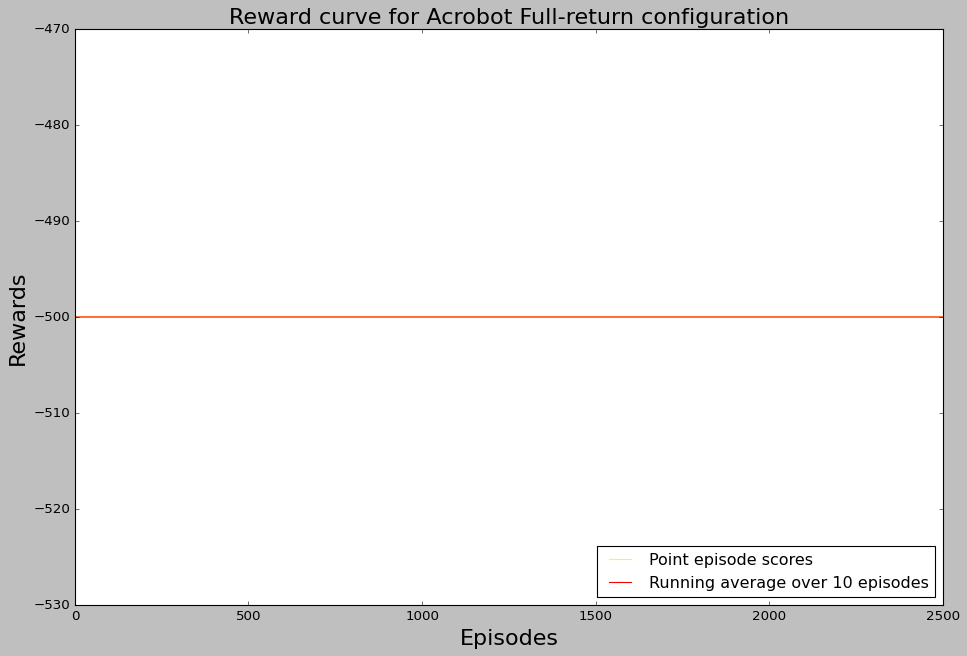

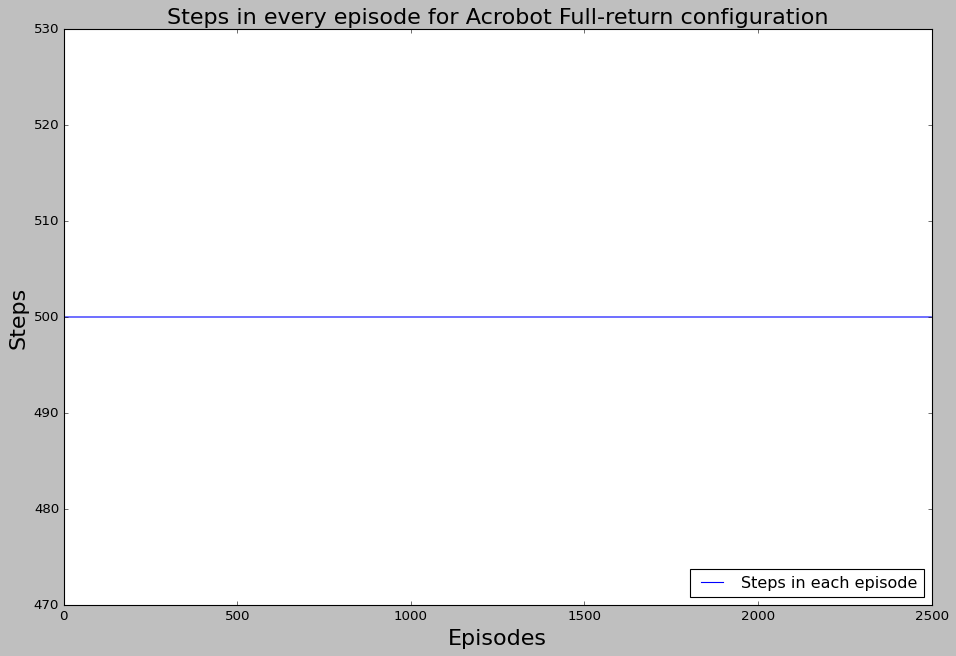

In [ ]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for Acrobot Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for Acrobot Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.show()

In [7]:
#Full-step with this code 1e-4 working but diverging.5e-4 not working
#Solved!. 1e-5 and n=4 but n not needed
env = gym.make('Acrobot-v1')
req_score=-200

#Initializing Agent
agent = Agent(lr=1e-5, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 2500

# tf.compat.v1.reset_default_graph()

gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=4
steps_his=[]

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew += reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,"full-step")
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 50 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  50 Reward -500.000000 Average Reward -500.000000
Episode  100 Reward -500.000000 Average Reward -474.400000
Episode  150 Reward -500.000000 Average Reward -493.400000
Episode  200 Reward -500.000000 Average Reward -453.400000
Episode  250 Reward -500.000000 Average Reward -434.600000
Episode  300 Reward -500.000000 Average Reward -493.400000
Episode  350 Reward -500.000000 Average Reward -446.900000
Episode  400 Reward -500.000000 Average Reward -491.500000
Episode  450 Reward -500.000000 Average Reward -452.200000
Episode  500 Reward -500.000000 Average Reward -475.700000
Episode  550 Reward -494.000000 Average Reward -454.300000
Episode  600 Reward -303.000000 Average Reward -462.200000
Episode  650 Reward -500.000000 Average Reward -488.100000
Episode  700 Reward -500.000000 Average Reward -500.000000
Episode  750 Reward -500.000000 Average Reward -463.800000
Episode  800 Reward -500.000000 Average Reward -480.200000
Episode  850 Reward -500.000000 Average Reward -500.00000

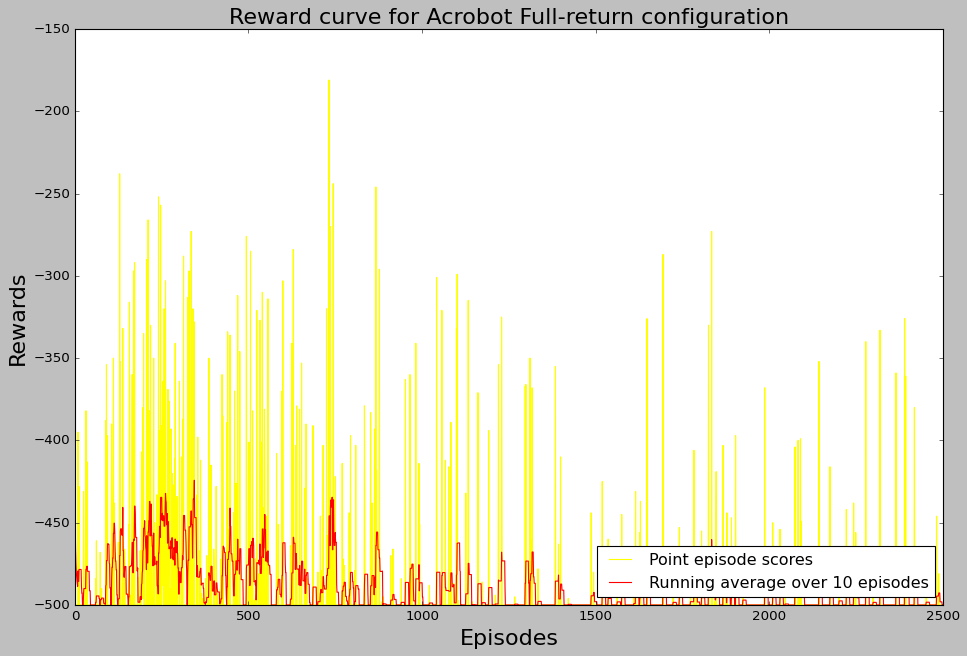

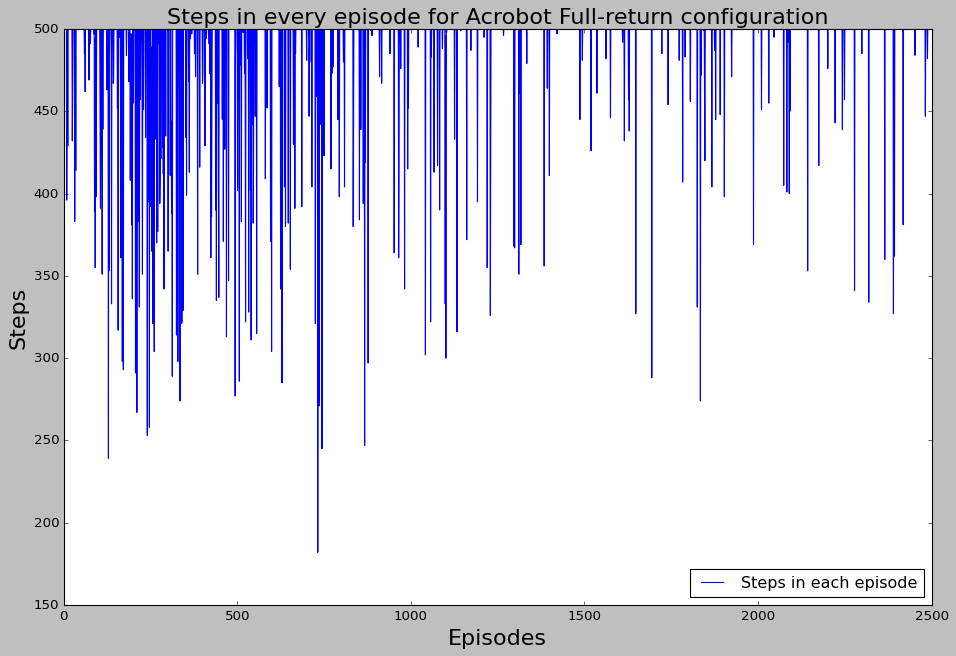

In [8]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for Acrobot Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for Acrobot Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.show()

In [9]:
#Full-step with this code 1e-4 working but diverging.5e-4 not working
#Solved!. 1e-5 and n=4 but n not needed
env = gym.make('Acrobot-v1')
req_score=-200

#Initializing Agent
agent = Agent(lr=1e-6, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 2500

# tf.compat.v1.reset_default_graph()

gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=4
steps_his=[]

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew += reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,"full-step")
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 50 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  50 Reward -500.000000 Average Reward -500.000000
Episode  100 Reward -453.000000 Average Reward -495.300000
Episode  150 Reward -500.000000 Average Reward -500.000000
Episode  200 Reward -500.000000 Average Reward -500.000000
Episode  250 Reward -500.000000 Average Reward -500.000000
Episode  300 Reward -500.000000 Average Reward -494.200000
Episode  350 Reward -500.000000 Average Reward -492.900000
Episode  400 Reward -500.000000 Average Reward -500.000000
Episode  450 Reward -500.000000 Average Reward -494.200000
Episode  500 Reward -500.000000 Average Reward -500.000000
Episode  550 Reward -500.000000 Average Reward -500.000000
Episode  600 Reward -500.000000 Average Reward -494.100000
Episode  650 Reward -500.000000 Average Reward -500.000000
Episode  700 Reward -500.000000 Average Reward -500.000000
Episode  750 Reward -500.000000 Average Reward -496.900000
Episode  800 Reward -431.000000 Average Reward -493.100000
Episode  850 Reward -500.000000 Average Reward -500.00000

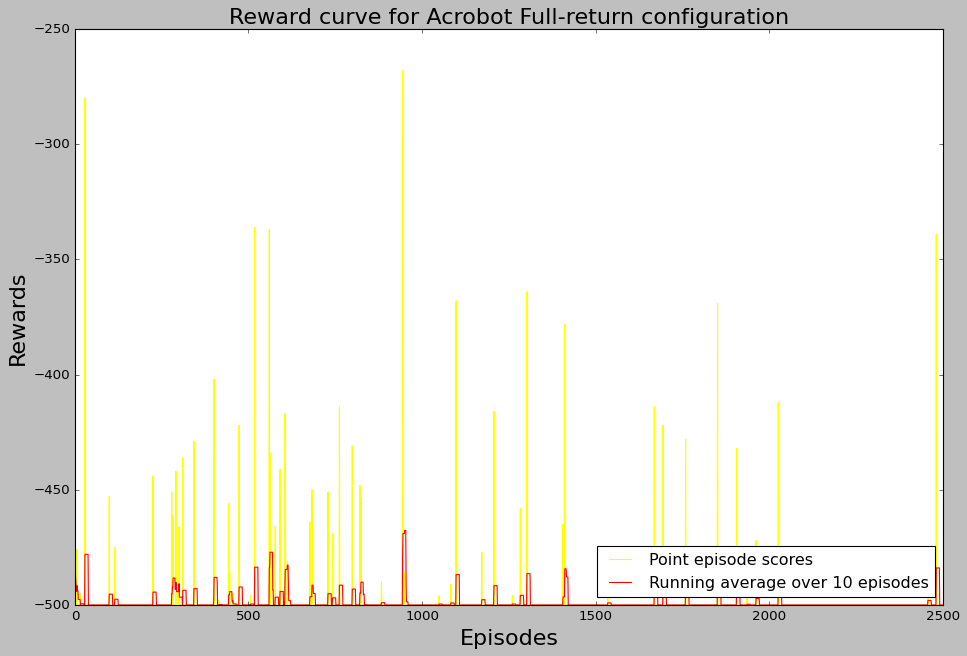

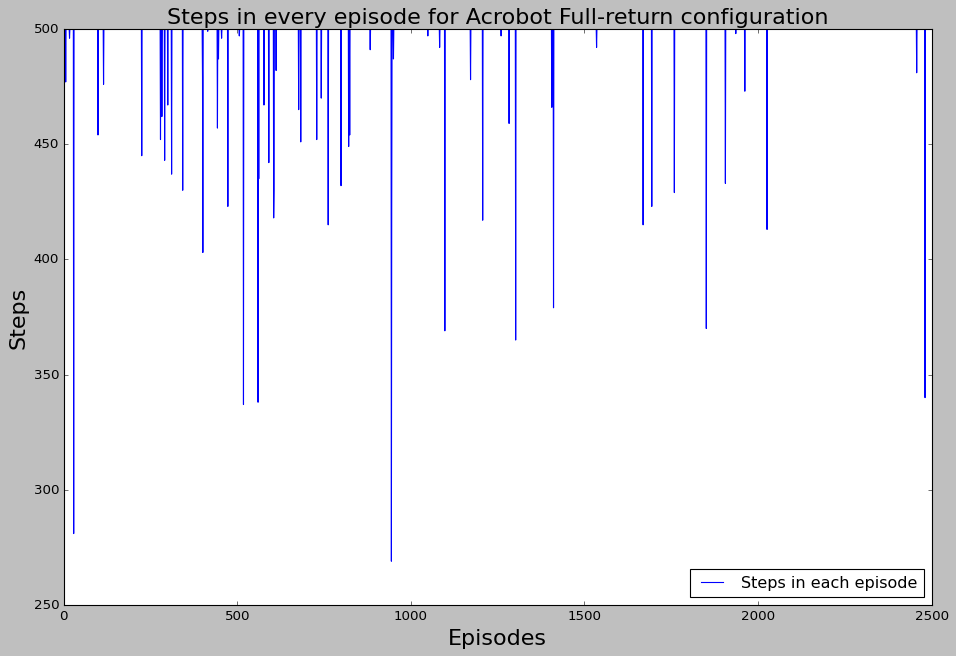

In [10]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for Acrobot Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for Acrobot Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.show()

In [5]:
#Full-step with this code 1e-4 working but diverging.5e-4 not working
#Solved!. 1e-5 and n=4 but n not needed
env = gym.make('Acrobot-v1')
req_score=-200

#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 2500

# tf.compat.v1.reset_default_graph()

gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=4
steps_his=[]

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew += reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,"full-step")
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 50 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  50 Reward -500.000000 Average Reward -500.000000
Episode  100 Reward -500.000000 Average Reward -489.900000
Episode  150 Reward -500.000000 Average Reward -500.000000
Episode  200 Reward -500.000000 Average Reward -500.000000
Episode  250 Reward -500.000000 Average Reward -500.000000
Episode  300 Reward -500.000000 Average Reward -500.000000
Episode  350 Reward -500.000000 Average Reward -500.000000
Episode  400 Reward -500.000000 Average Reward -500.000000
Episode  450 Reward -500.000000 Average Reward -500.000000
Episode  500 Reward -500.000000 Average Reward -500.000000
Episode  550 Reward -500.000000 Average Reward -500.000000
Episode  600 Reward -500.000000 Average Reward -500.000000
Episode  650 Reward -500.000000 Average Reward -500.000000
Episode  700 Reward -500.000000 Average Reward -500.000000
Episode  750 Reward -500.000000 Average Reward -500.000000
Episode  800 Reward -500.000000 Average Reward -500.000000
Episode  850 Reward -500.000000 Average Reward -500.00000

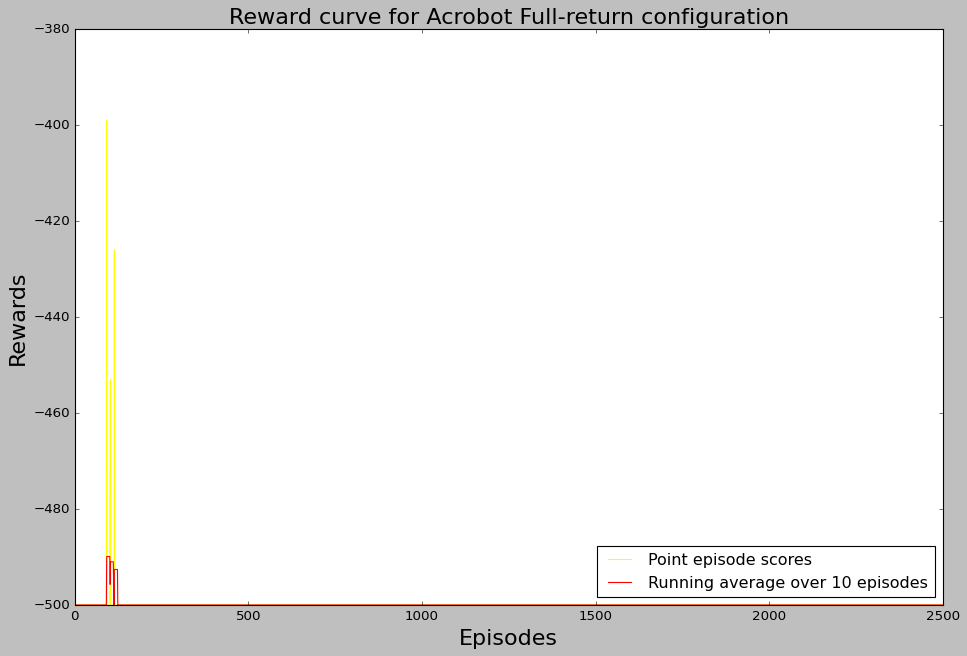

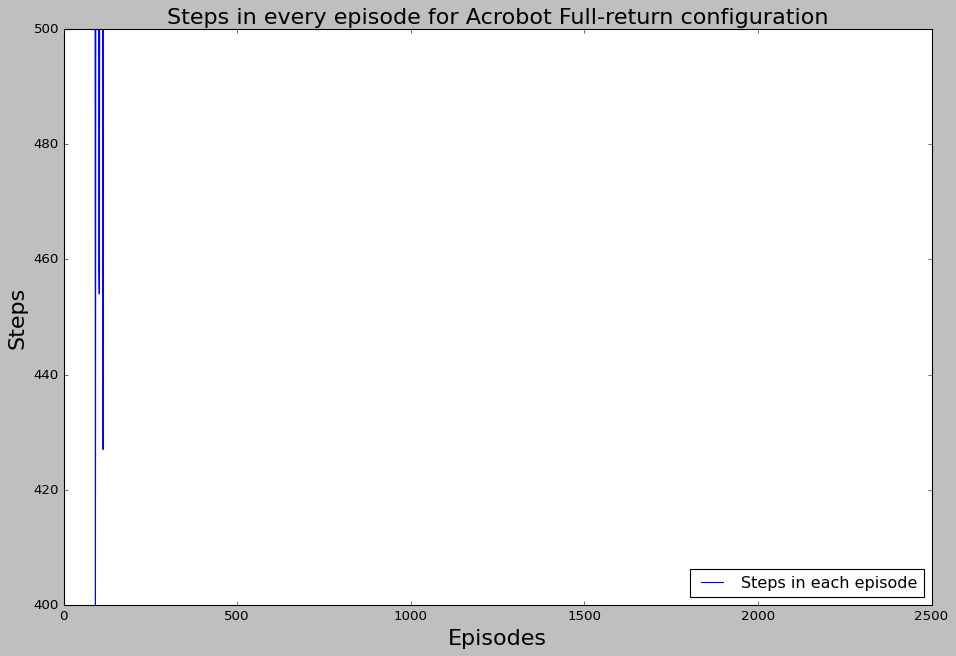

In [6]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for Acrobot Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for Acrobot Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.show()

# $MountainCar\:$
n-step return configuration

In [ ]:
#n step

env = gym.make('MountainCar-v0')
req_score=-200

#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 3000
# tf.compat.v1.reset_default_graph()
gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=5 
steps_his=[]
reward_his=[]
for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew =ep_rew+ reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,'n-step')
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 100 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  100 Reward -200.000000 Average Reward -200.000000
Episode  200 Reward -200.000000 Average Reward -200.000000
Episode  300 Reward -200.000000 Average Reward -200.000000
Episode  400 Reward -200.000000 Average Reward -200.000000
Episode  500 Reward -200.000000 Average Reward -200.000000
Episode  600 Reward -200.000000 Average Reward -200.000000
Episode  700 Reward -200.000000 Average Reward -200.000000
Episode  800 Reward -200.000000 Average Reward -200.000000
Episode  900 Reward -200.000000 Average Reward -200.000000
Episode  1000 Reward -200.000000 Average Reward -200.000000
Episode  1100 Reward -200.000000 Average Reward -200.000000
Episode  1200 Reward -200.000000 Average Reward -200.000000
Episode  1300 Reward -200.000000 Average Reward -200.000000
Episode  1400 Reward -200.000000 Average Reward -200.000000
Episode  1500 Reward -200.000000 Average Reward -200.000000
Episode  1600 Reward -200.000000 Average Reward -200.000000
Episode  1700 Reward -200.000000 Average Reward -

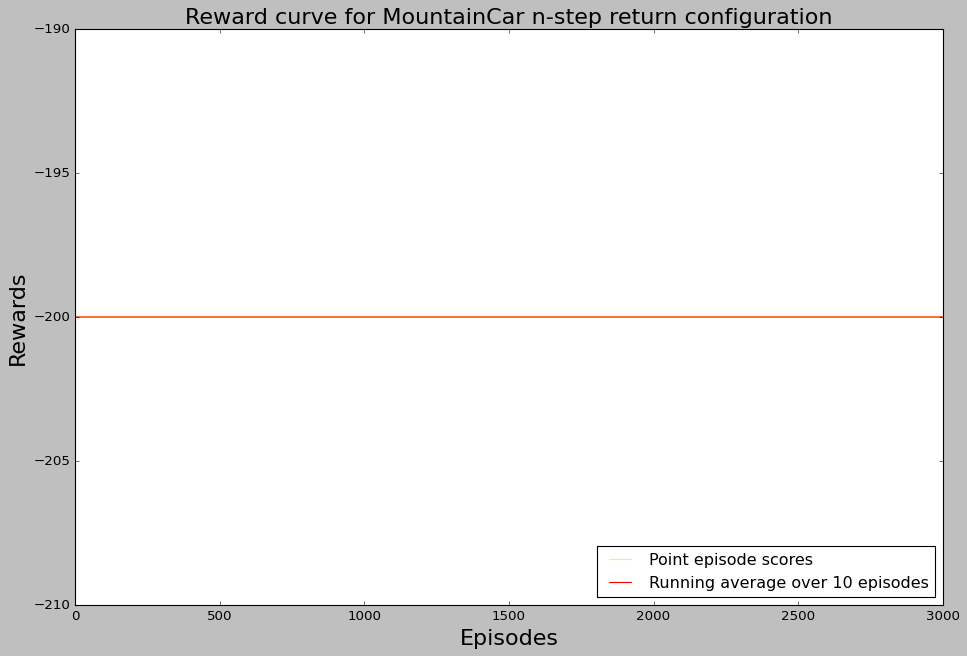

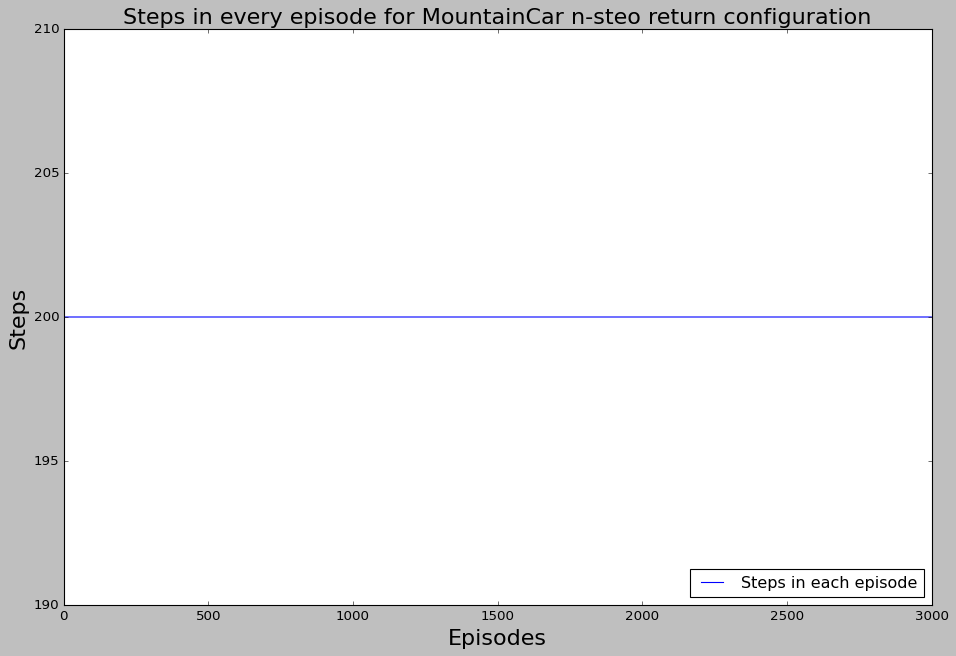

In [ ]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for MountainCar n-step return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for MountainCar n-step return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.show()

# $MountainCar\:$
Full-return configuration

In [5]:
#Full step 1e-3 not at all. 1e-2 no

env = gym.make('MountainCar-v0')
req_score=-200

#Initializing Agent
agent = Agent(lr=1e-4, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 1000

# tf.compat.v1.reset_default_graph()
gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=5 #not needed
steps_his=[]

for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew =ep_rew+ reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,'full-step')
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 50 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  50 Reward -200.000000 Average Reward -200.000000
Episode  100 Reward -200.000000 Average Reward -200.000000
Episode  150 Reward -200.000000 Average Reward -200.000000
Episode  200 Reward -200.000000 Average Reward -200.000000
Episode  250 Reward -200.000000 Average Reward -200.000000
Episode  300 Reward -200.000000 Average Reward -200.000000
Episode  350 Reward -200.000000 Average Reward -200.000000
Episode  400 Reward -200.000000 Average Reward -200.000000
Episode  450 Reward -200.000000 Average Reward -200.000000
Episode  500 Reward -200.000000 Average Reward -200.000000
Episode  550 Reward -200.000000 Average Reward -200.000000
Episode  600 Reward -200.000000 Average Reward -200.000000
Episode  650 Reward -200.000000 Average Reward -200.000000
Episode  700 Reward -200.000000 Average Reward -200.000000
Episode  750 Reward -200.000000 Average Reward -200.000000
Episode  800 Reward -200.000000 Average Reward -200.000000
Episode  850 Reward -200.000000 Average Reward -200.00000

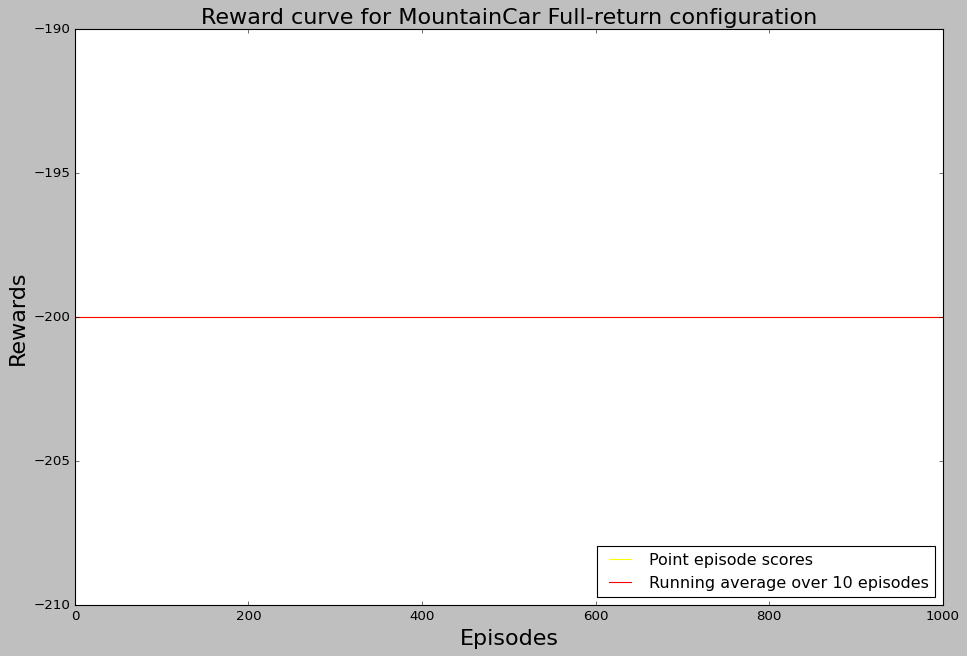

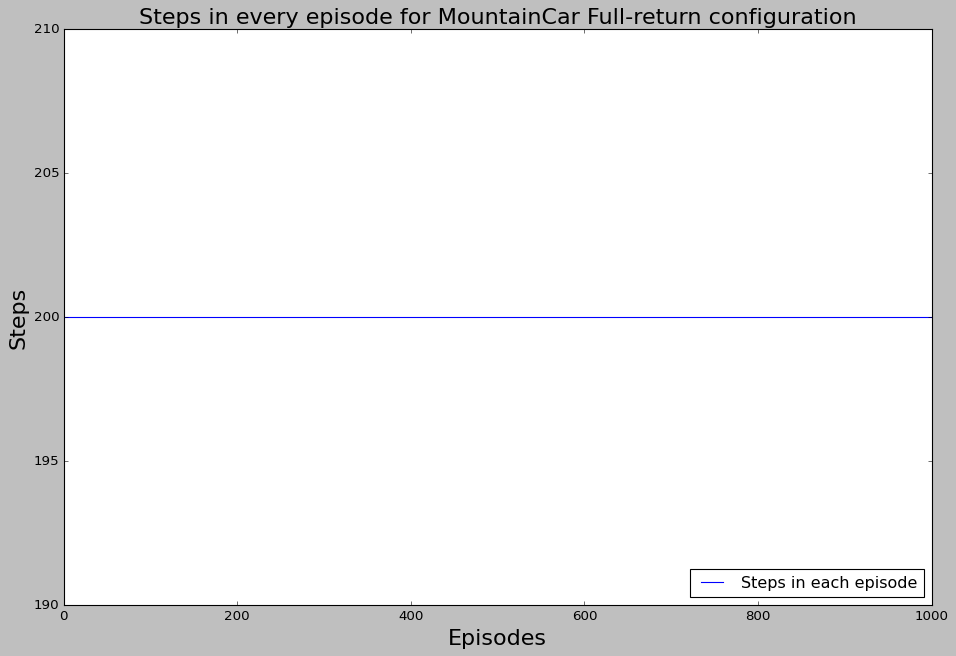

In [6]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for MountainCar Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for MountainCar Full-return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.show()

# $MountainCar\:$
n-step return configuration

In [7]:
#n step

env = gym.make('MountainCar-v0')
req_score=-200

#Initializing Agent
agent = Agent(lr=1e-3, action_size=env.action_space.n,input_size=env.reset().shape[0])

#Number of episodes
episodes = 1000
# tf.compat.v1.reset_default_graph()
gamma=0.99
reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()
N=100
steps_his=[]
reward_his=[]
for ep in range(1, episodes + 1):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0

    states=[]
    actions=[]
    rewards=[]
    states.append(torch.from_numpy(state))
    i=0
    while not done:

      action = agent.sample_action(torch.from_numpy(state)) ##Sample Action
      next_state, reward, done, info = env.step(action) ##Take action
      next_state = next_state.reshape(1,-1)
      ep_rew =ep_rew+ reward  ##Updating episode reward
      state = next_state ##Updating State
      actions.append(action)
      states.append(torch.from_numpy(state))
      rewards.append(reward)
      i+=1
    agent.learn(states,actions,rewards,N,'n-step')
    reward_list.append(ep_rew)
    steps_his.append(i)
    average_reward_list.append(np.mean(reward_list[-10:]))

    if ep % 100 == 0:
        avg_rew = np.mean(reward_list[-10:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 100:
        avg_100 =  np.mean(reward_list[-100:])
        if avg_100 > req_score:
            print('Stopped at Episode ',ep)
            break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode  100 Reward -200.000000 Average Reward -200.000000
Episode  200 Reward -200.000000 Average Reward -200.000000
Episode  300 Reward -200.000000 Average Reward -200.000000
Episode  400 Reward -200.000000 Average Reward -200.000000
Episode  500 Reward -200.000000 Average Reward -200.000000
Episode  600 Reward -200.000000 Average Reward -200.000000
Episode  700 Reward -200.000000 Average Reward -200.000000
Episode  800 Reward -200.000000 Average Reward -200.000000
Episode  900 Reward -200.000000 Average Reward -200.000000
Episode  1000 Reward -200.000000 Average Reward -200.000000
0:13:40.778766


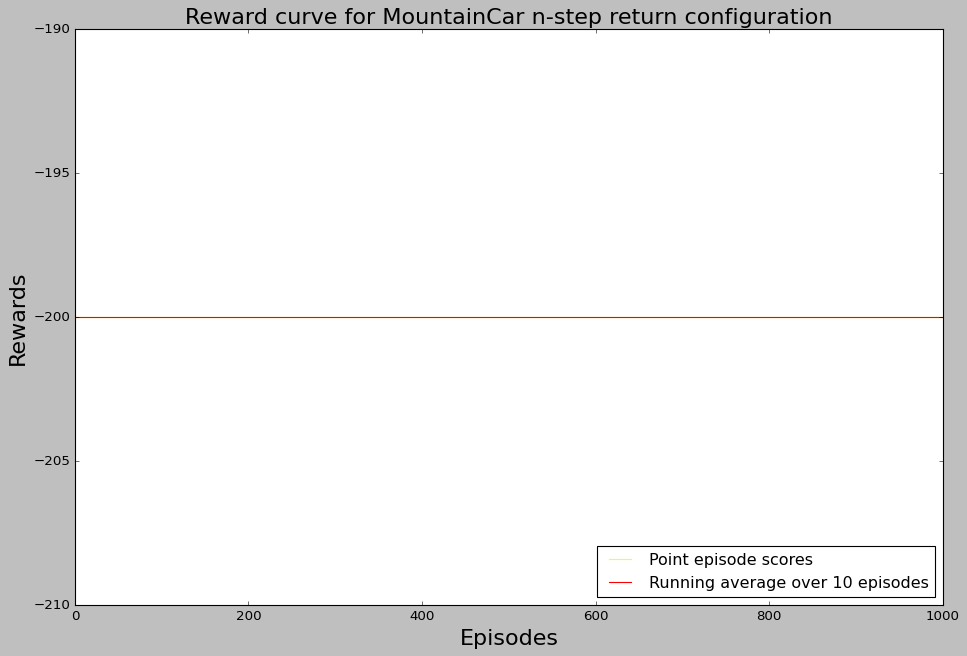

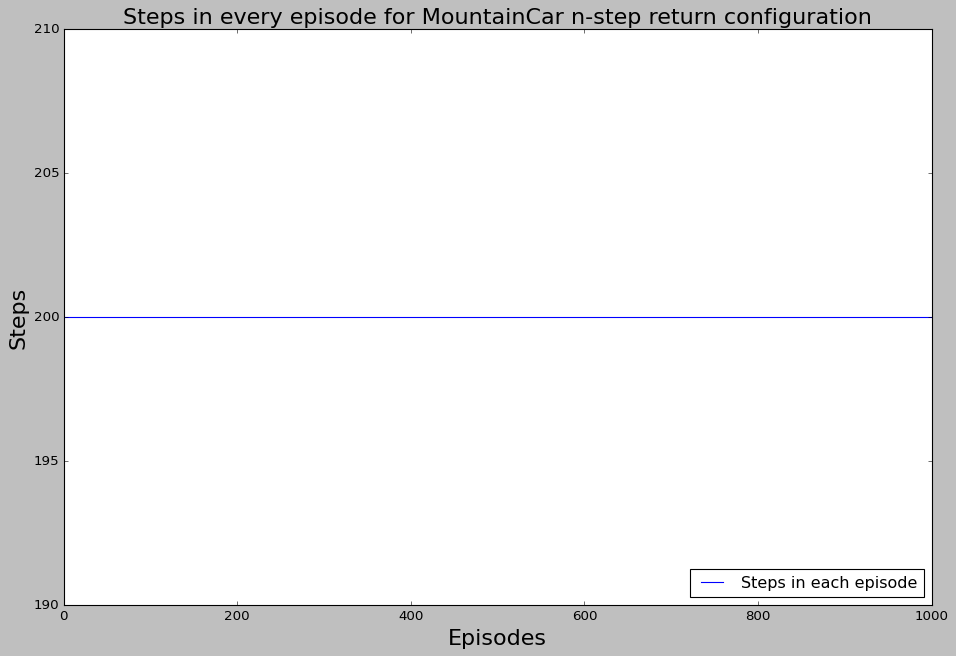

In [8]:
plt.style.use('classic')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(reward_list)),reward_list,label='Point episode scores',color='yellow')
plt.plot(np.arange(len(average_reward_list)),average_reward_list,label='Running average over 10 episodes',color='red')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title('Reward curve for MountainCar n-step return configuration (n=100)',fontsize=20)
plt.legend(loc='lower right')
plt.figure(figsize=(14,9))
plt.plot(np.arange(len(steps_his)),steps_his,label='Steps in each episode')
plt.xlabel('Episodes',fontsize=20)
plt.ylabel('Steps',fontsize=20)
plt.title('Steps in every episode for MountainCar n-step return configuration',fontsize=20)
plt.legend(loc='lower right')
plt.show()